In [6]:
import pickle
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import cv2
import os
from collections import defaultdict


### Сбор и сохранение масок сегментации

In [4]:
def create_masks_for_all_images(data, output_dir='masks'):
    os.makedirs(output_dir, exist_ok=True)
    images_dict = defaultdict(list)
    
    for idx, row in data.iterrows():
        file_name = row['file_name']
        segmentation = row['segmentation']
        class_id = row['category_id']
        
        images_dict[file_name].append({
            'segmentation': segmentation,
            'class_id': class_id,
            'index': idx
        })
    
    print(f'Найдено {len(images_dict)} уникальных изображений')
    print(f'Всего объектов: {len(data)}')
    
    masks_info = []
    print_every = 250
    
    for idx, (file_name, objects) in enumerate(images_dict.items()):
        img_path = f'../train/{file_name}'
        img = cv2.imread(img_path)
        
        height, width = img.shape[:2]
        mask = np.zeros((height, width), dtype=np.uint8)
        
        for obj in objects:
            segmentation = obj['segmentation']
            class_id = obj['class_id']
            
            points = np.array(segmentation, dtype=np.int32).reshape((-1, 2))
            points_poly = points.reshape((-1, 1, 2))

            if class_id == 1:
                cv2.fillPoly(mask, [points_poly], 1)
            elif class_id == 2:
                cv2.fillPoly(mask, [points_poly], 2)
            else:
                print(f"Неизвестный class_id: {class_id}")
        
        mask_filename = file_name.replace('.jpg', '.png')
        mask_path = os.path.join(output_dir, mask_filename)
        cv2.imwrite(mask_path, mask)

        masks_info.append({
            'file_name': file_name,
            'mask_name': mask_filename,
            'num_objects': len(objects),
            'classes': [obj['class_id'] for obj in objects],
            'image_size': (height, width)
        })

        if idx % print_every == 0:
            print(f'Создана маска для {file_name}: {len(objects)} объектов, классы: {set([obj["class_id"] for obj in objects])}')
    
    print(f'\nВсего создано масок: {len(masks_info)}')
    return masks_info

def save_masks_info(masks_info, output_path='../masks/masks_info.pkl'):
    with open(output_path, 'wb') as f:
        pickle.dump(masks_info, f)
        
    print(f'Информация о масках сохранена в {output_path}')

In [5]:
data = pd.read_pickle('../data/dataset.pkl')
masks_info = create_masks_for_all_images(data, output_dir='../masks')
save_masks_info(masks_info, '../masks/masks_info.pkl')

print('Маски сгенерированы')

Найдено 994 уникальных изображений
Всего объектов: 2962
Создана маска для GX010295_MP4-0209_jpg.rf.PZmnbs7l0UPtX5vmTXNo.jpg: 3 объектов, классы: {1, 2}
Создана маска для GX010295_MP4-0047_jpg.rf.17206LVDnRCvEbxFiqIA.jpg: 3 объектов, классы: {1, 2}
Создана маска для GX010296_MP4-0240_jpg.rf.99l8RUPOhS0qgcMVcPRT.jpg: 3 объектов, классы: {1, 2}
Создана маска для GX010294_MP4-0183_jpg.rf.uAzzaBNDWKcMjt95gIYs.jpg: 3 объектов, классы: {1, 2}

Всего создано масок: 994
Информация о масках сохранена в ../masks/masks_info.pkl
Маски сгенерированы


___
### Визуализация сгенерированных масок мультиклассовой сегментации

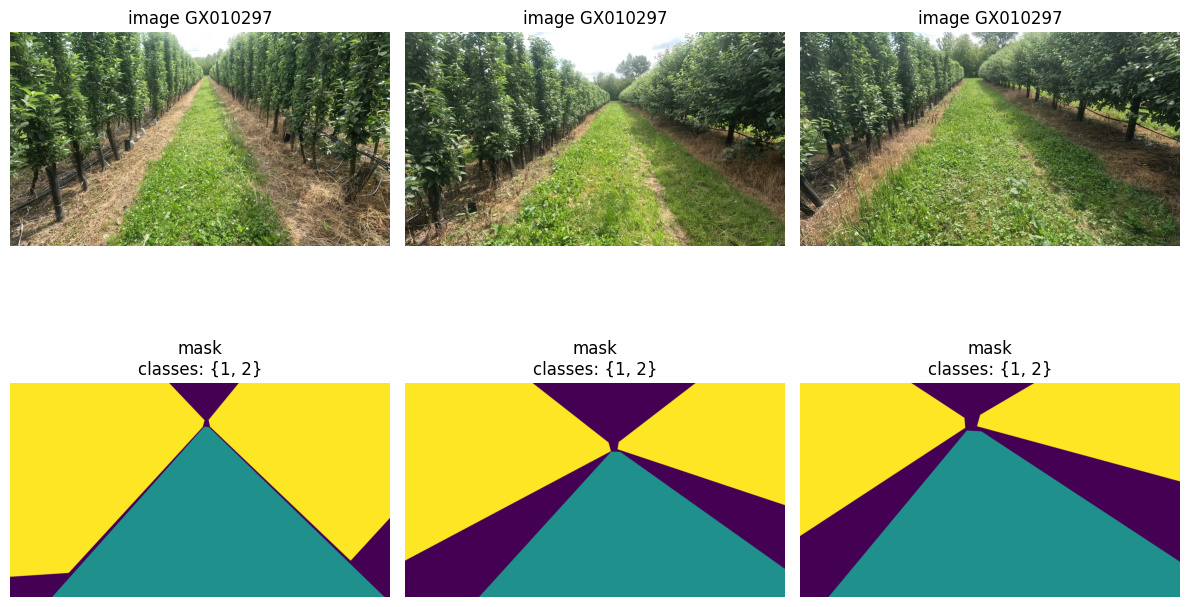

In [7]:
def visualize_masks(masks_info, num_examples=3):
    samples = random.sample(masks_info, min(num_examples, len(masks_info)))
    fig, axes = plt.subplots(2, len(samples), figsize=(4*len(samples), 8))
    
    for i, s in enumerate(samples):
        img = cv2.cvtColor(cv2.imread(f'../train/{s["file_name"]}'), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(f'../masks/{s["mask_name"]}', cv2.IMREAD_GRAYSCALE)
        
        axes[0, i].imshow(img)
        axes[0, i].set_title('image ' + s["file_name"].split('_')[0])
        axes[0, i].axis('off')
        
        axes[1, i].imshow(mask)
        axes[1, i].set_title(f'mask\nclasses: {set(s["classes"])}')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

with open('../masks/masks_info.pkl', 'rb') as f:
    masks_info = pickle.load(f)
    
visualize_masks(masks_info, 3)